In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm; tqdm.pandas()
pd.options.display.max_columns = 202
pd.options.display.max_rows = 300

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]

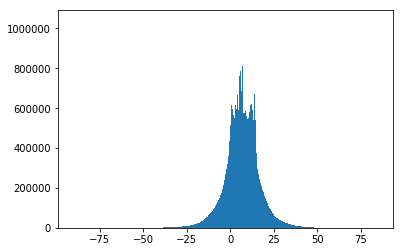

In [3]:
all_values = pd.concat([train[feature_cols], test[feature_cols]], axis=0).reset_index(drop=True).values.flatten()
all_values = pd.Series(all_values)
plt.hist(all_values, bins=1000); plt.show()

In [4]:
def add_noise(series, noise_level): 
    return series * (1 + noise_level * np.random.randn(len(series)))
                     
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
                      
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [5]:
flatten_train = pd.DataFrame()
flatten_train['original_values'] = np.concatenate(train[feature_cols].values)
flatten_train['target'] = np.concatenate([[t]*len(feature_cols) for t in train.target])
print(flatten_train.shape)
flatten_train.head(3)

flatten_test = pd.DataFrame()
flatten_test['original_values'] = np.concatenate(test[feature_cols].values)

(40000000, 2)


In [6]:
trn_me, tst_me = target_encode(flatten_train['original_values'], 
                                flatten_test['original_values'], 
                                target=flatten_train.target,  
                                min_samples_leaf=100,
                                smoothing=10,
                                noise_level=0.01)

In [7]:
flatten_train['target_enc'] = trn_me.values
flatten_test['target_enc'] = tst_me.values

In [8]:
trn_me_mapping = flatten_train.groupby('original_values')['target_enc'].mean()
tst_me_mapping = flatten_test.groupby('original_values')['target_enc'].mean()

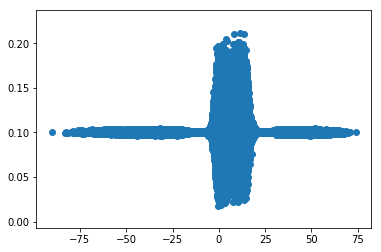

In [9]:
plt.scatter(trn_me_mapping.index, trn_me_mapping.values); plt.show()

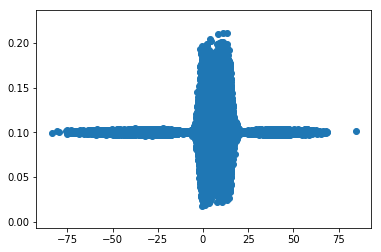

In [10]:
plt.scatter(tst_me_mapping.index, tst_me_mapping.values); plt.show()

In [11]:
all_vc = all_values.value_counts()
all_vc_df = pd.DataFrame(index=all_vc.index)
all_vc_df['count'] = all_vc.values
all_vc_df = all_vc_df.sort_index(ascending=True)
all_vc_df['opposite_count'] = all_vc_df['count'].values[-1::-1]

all_vc_df

,count,opposite_count
-90.2525,1,1
-83.6921,1,1
-83.1075,1,1
-82.2573,1,1
-82.1271,1,1
-81.4005,1,1
-80.8747,2,1
-79.8153,1,1
-79.6336,1,2
-78.9641,1,2


In [12]:
all_vc_df['count_opposite_diff'] = all_vc_df['count']-all_vc_df['opposite_count']

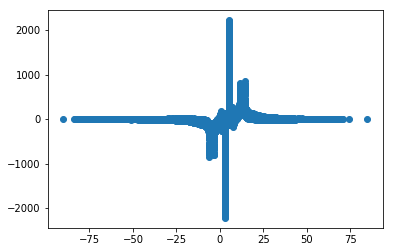

In [13]:
plt.scatter(all_vc_df.index, all_vc_df.count_opposite_diff.values); plt.show()

In [14]:
for col in tqdm(feature_cols):
    train[col+'_cnt_enc'] = train[col].map(all_vc_df['count_opposite_diff'])
    test[col+'_cnt_enc'] = test[col].map(all_vc_df['count_opposite_diff'])

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.71it/s]


In [15]:
new_feats = [f+'_cnt_enc' for f in feature_cols]
for df in [train, test]:
    df['cnt_enc_sum'] = df[new_feats].sum(axis=1)
    df['cnt_enc_std'] = df[new_feats].std(axis=1)
new_feats += ['cnt_enc_sum', 'cnt_enc_std']

In [17]:
train[['target']+new_feats].iloc[:10000].corr('spearman').sort_values('target', ascending=False)[['target']]

,target
target,1.000000
var_190_cnt_enc,0.043602
var_26_cnt_enc,0.043244
var_1_cnt_enc,0.041071
var_170_cnt_enc,0.040697
var_22_cnt_enc,0.037571
var_35_cnt_enc,0.035296
var_106_cnt_enc,0.034710
var_179_cnt_enc,0.034526
var_173_cnt_enc,0.032496


In [16]:
train[new_feats].to_pickle('features/all_items_opposite_rank_count_encode_train_v1.pkl')
test[new_feats].to_pickle('features/all_items_opposite_rank_count_encode_test_v1.pkl')